In [1]:
import warnings
warnings.filterwarnings(action="ignore")

import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm

from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

import torch
from torch import nn
from torchinfo import summary
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms as T

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

device

'cuda:0'

In [3]:
df = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")

print(df.shape)

df.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
df.columns

Index(['id', 'breed'], dtype='object')

In [5]:
def join_path(x:str):
    if not x.endswith(".jpg"):
        x = os.path.join("/kaggle/input/dog-breed-identification/train", x+".jpg")
    else:
        x = os.path.join("/kaggle/input/dog-breed-identification/train", x)
    
    return x

In [6]:
df["id"] = df["id"].apply(lambda x: join_path(x))

In [7]:
def PlotTargetDist(df:pd.DataFrame):
    barplot = df["breed"].value_counts().plot(kind="bar", title="Target distribution", xlabel="Breed", ylabel="Counts")
    
    for p in barplot.patches:
        h = p.get_height()
        barplot.text(p.get_x()+(p.get_width()/2), h, h, va="bottom", ha="center")
    
    barplot.set_xticklabels(labels=barplot.get_xticklabels(), rotation=45)

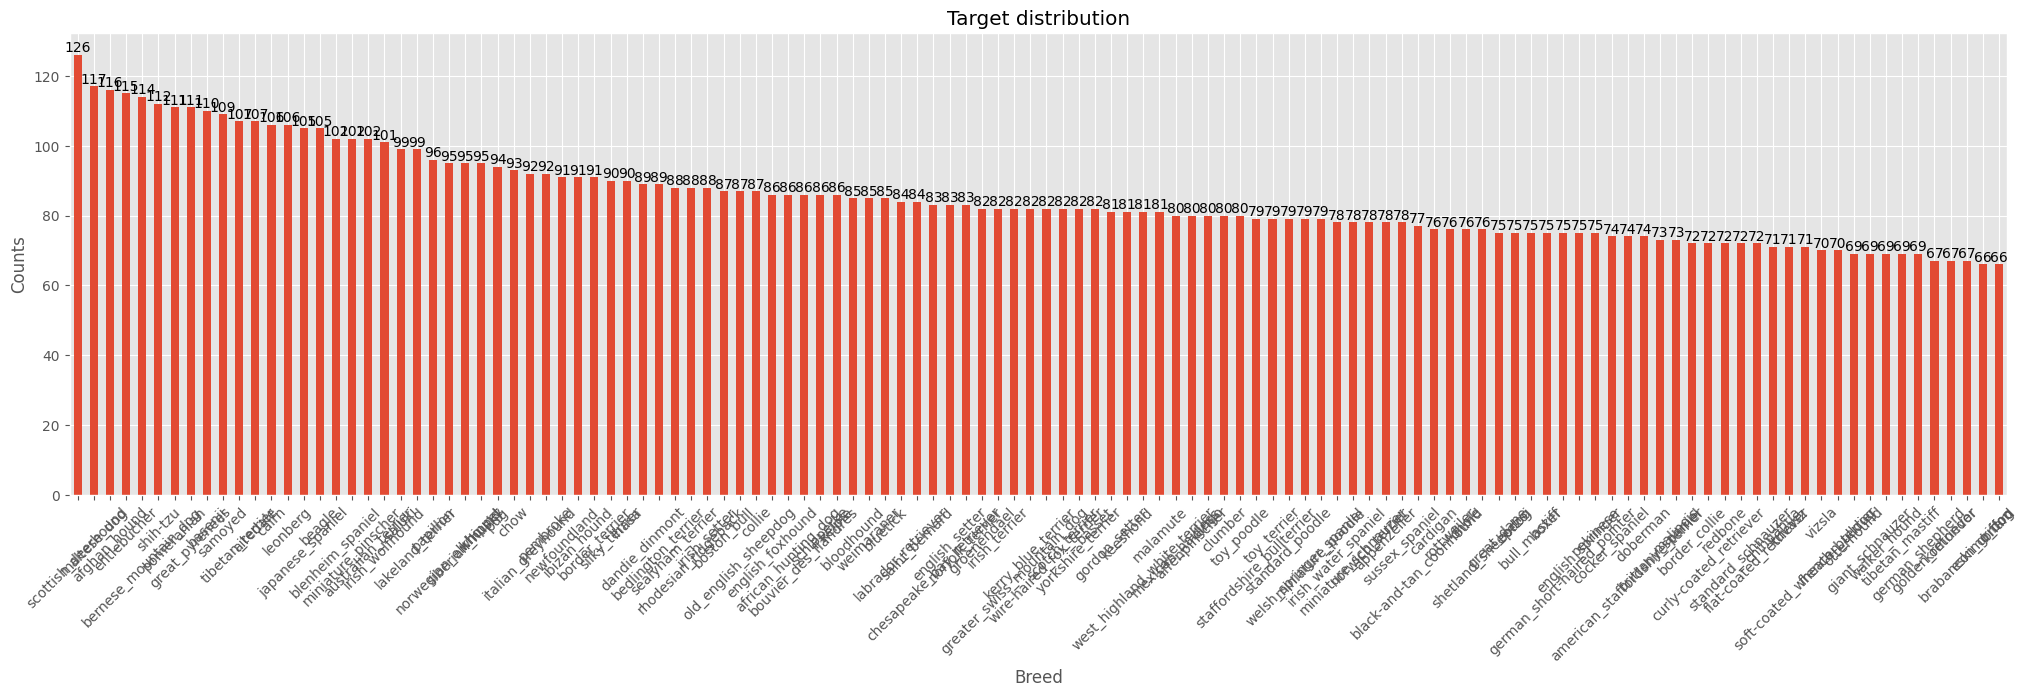

In [8]:
plt.figure(figsize=(25, 6))

PlotTargetDist(df)

plt.show()

In [9]:
n_class = len(df["breed"].unique())
n_class

120

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df["id"], df["breed"], stratify=df["breed"], test_size=.1,random_state=42)

train_df = pd.concat([Xtrain, ytrain], axis=1)
test_df =  pd.concat([Xtest, ytest], axis=1)

print(train_df.shape, test_df.shape)

(9199, 2) (1023, 2)


In [11]:
encoder = LabelEncoder()

train_df["encoded_breed"] = encoder.fit_transform(train_df["breed"])
test_df["encoded_breed"] = encoder.fit_transform(test_df["breed"])

In [12]:
class_indices = {i:j for i, j in zip(range(len(encoder.classes_)), encoder.classes_)}

class_indices

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph

In [56]:
class ImageData(Dataset):
    def __init__(self, df: pd.DataFrame, prep=None, aug=None):
        super(ImageData, self).__init__()
        self.X = df["id"]
        self.y = df["encoded_breed"]
        self.p = prep
        
        if (not aug):
            self.aug = T.Compose([
                T.ToTensor(),
                T.Resize((224, 224)),
                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
            
        else:
            self.aug = aug
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        get_image = self.X.iloc[index]
        get_label = self.y.iloc[index]
        
        load_image = Image.open(get_image).convert("RGB")
        
        augment_image = self.aug(load_image)
        
        if self.p:
            return self.p.transforms()(augment_image), get_label
        
        return augment_image, get_label

In [14]:
train_ds = ImageData(df=train_df)
test_ds = ImageData(df=test_df)

train_dl = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(dataset=test_ds, batch_size=32, shuffle=True)

In [15]:
img, lbl = next(iter(train_dl))

In [16]:
def PLotBatchImage():
    rand_indices = np.random.randint(0, 32, 9)
    
    plt.figure(figsize=(12, 12))
    for i in range(1, 10):
        plt.subplot(3, 3, i)
        plt.imshow(torch.permute(img[rand_indices[i-1]], (2, 1, 0)), cmap="gray")
        plt.title(f"{class_indices[lbl[rand_indices[i-1]].item()]}")
        plt.axis(False)
    
    plt.show()

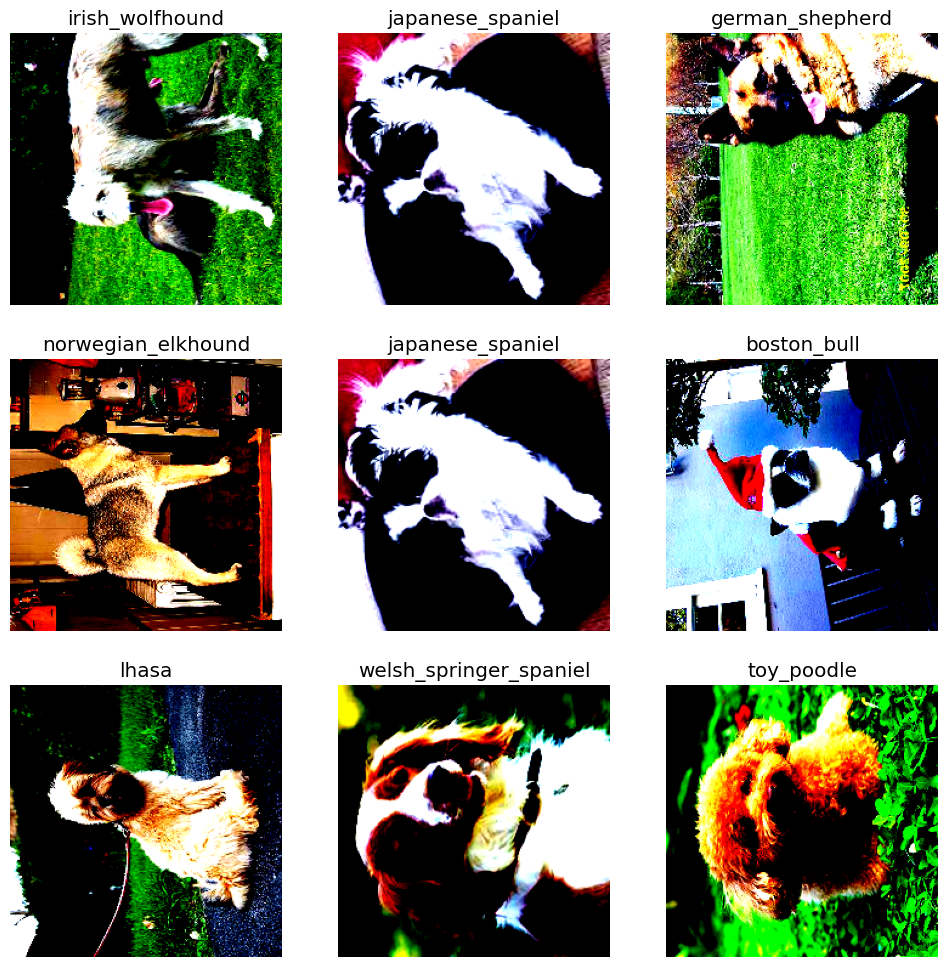

In [17]:
PLotBatchImage()

In [18]:
base_model = models.resnet50(pretrained=True)

# Freeze layers 
for param in base_model.parameters():
    param.requires_grad = False
    
base_model.fc = nn.Linear(base_model.fc.in_features, 120)

base_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [96]:
loss_func = nn.CrossEntropyLoss()
optim_func = torch.optim.Adam(base_model.parameters(), lr=0.001)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_func, patience=2, min_lr=1e-5)

def TrainModelPerEpoch(model, train_dl, device):
    
    train_acc, train_loss = 0, 0
    
    model.train()
    
    for X, y in train_dl:
        img, lbl = X.to(device), y.to(device)
        optim_func.zero_grad()
        prediction = model(img)
        loss = loss_func(prediction, lbl)
        n_correct = torch.sum(torch.argmax(prediction, dim=1) == lbl).item()
            
        train_acc += n_correct / len(prediction)
        train_loss += loss.item()
            
        optim_func.zero_grad()
        loss.backward()
        optim_func.step()
    
    total_acc = train_acc / len(train_dl)
    total_loss = train_loss / len(train_dl)
    
    return total_acc, total_loss
    
def ValidModelPerEpoch(model, test_dl, device):
    
    valid_acc, valid_loss = 0, 0
    
    model.eval()
    
    with torch.inference_mode():
        for X, y in test_dl:
            img, lbl = X.to(device), y.to(device)
            prediction = model(img)
            loss = loss_func(prediction, lbl)
            n_correct = torch.sum(torch.argmax(prediction, dim=1) == lbl).item()

            valid_acc += n_correct / len(prediction)
            valid_loss += loss.item()
    
    total_acc = valid_acc / len(test_dl)
    total_loss = valid_loss / len(test_dl)
    
    return total_acc, total_loss

In [97]:
def TrainModel(epochs, train_dl, test_dl, algo, device):
    history = {"train_accuracy":[],
              "train_loss":[],
              "val_accuracy":[],
              "val_loss":[]}

    for i in tqdm(range(epochs)):
        train_accuracy, train_loss_ = TrainModelPerEpoch(algo, train_dl, device)
        test_accuracy, test_loss_ = ValidModelPerEpoch(algo, test_dl, device)
        
        lr_schedule.step(test_loss_)
        
        print(f"epoch:{i+1}/{epochs}  train_acc:{train_accuracy} - train_loss:{train_loss_} - val_acc:{test_accuracy} - val_loss:{test_loss_}")
        
        history["train_accuracy"].append(train_accuracy)
        history["train_loss"].append(train_loss_)
        history["val_accuracy"].append(test_accuracy)
        history["val_loss"].append(test_loss_)
        
    return {"model":algo, "history":history}

In [21]:
history_of_model = TrainModel(20, train_dl, test_dl, base_model, device)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch:1/20  train_acc:0.5807942708333333 - train_loss:1.8778195859243472 - val_acc:0.7594506048387096 - val_loss:0.8595542479306459
epoch:2/20  train_acc:0.7929759837962963 - train_loss:0.73715538231449 - val_acc:0.7810609879032258 - val_loss:0.7572598978877068
epoch:3/20  train_acc:0.8339265046296296 - train_loss:0.5685690297331247 - val_acc:0.7879284274193549 - val_loss:0.7270723348483443
epoch:4/20  train_acc:0.8551793981481481 - train_loss:0.4773909469238586 - val_acc:0.7878969254032258 - val_loss:0.7138845026493073
epoch:5/20  train_acc:0.8686631944444445 - train_loss:0.4281435467095839 - val_acc:0.7966859879032258 - val_loss:0.6965285050682724
epoch:6/20  train_acc:0.885619212962963 - train_loss:0.3668736861501303 - val_acc:0.7937878024193549 - val_loss:0.6846719719469547
epoch:7/20  train_acc:0.8935112847222223 - train_loss:0.3294568124692887 - val_acc:0.7868888608870968 - val_loss:0.7222399697639048
epoch:8/20  train_acc:0.907248263888889 - train_loss:0.29130267783895963 - val_

### Observation:
1. The model seems to be overfitting the data

In [ ]:
model_performance = pd.DataFrame(history_of_model["history"])

In [40]:
def PlotPerformance(df:pd.DataFrame):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    ax = ax.flatten()
    
    df[["train_accuracy", "val_accuracy"]].plot(title="Model Accuracy", xlabel="Number of Epochs", ylabel="Accuracy", ax=ax[0])
    
    df[["train_loss", "val_loss"]].plot(title="Model Loss", xlabel="Number of Epochs", ylabel="Loss", ax=ax[1])
    
    plt.tight_layout()
    
    plt.show()

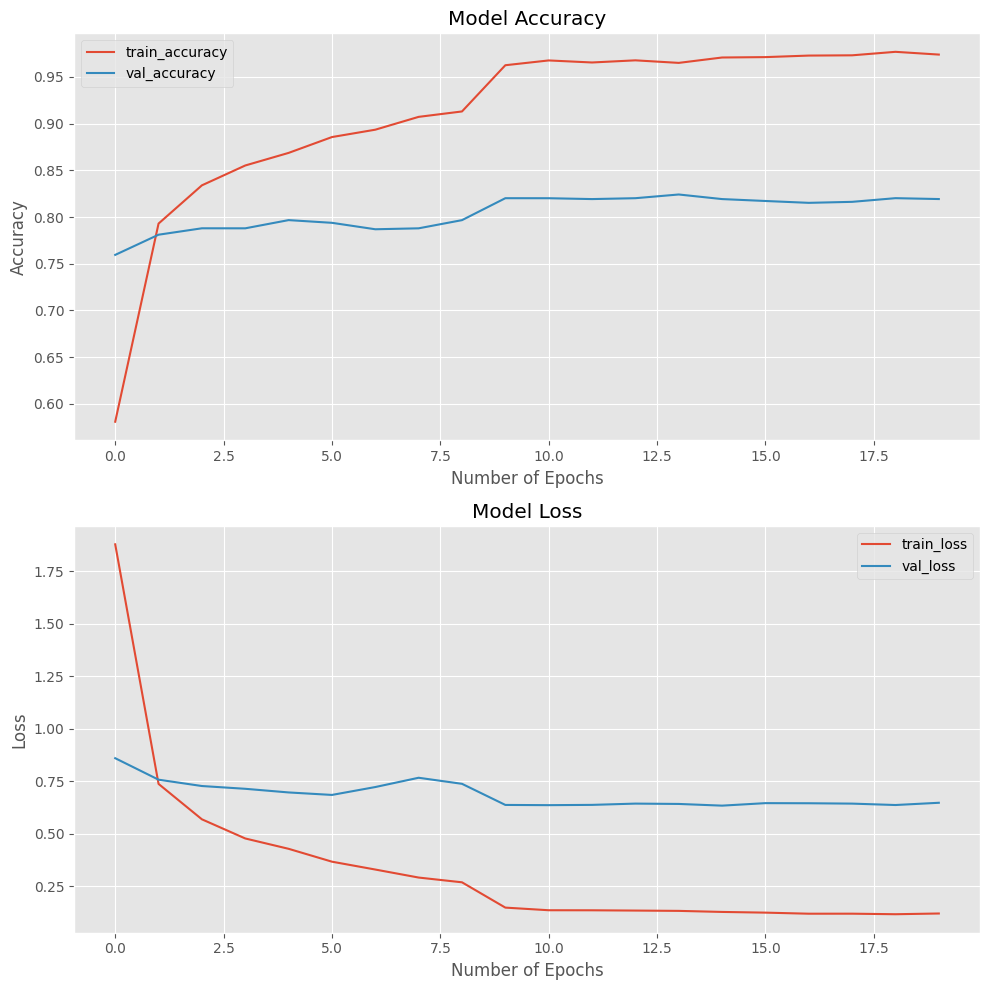

In [41]:
PlotPerformance(model_performance)

## Model improvement is allowed.